<a href="https://colab.research.google.com/github/Bast-94/RL-DQN/blob/dqn-draft/RL-DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet de Reinforcement Learning : Deep Q-Learning sur le casse-brique d'Atari

In [50]:
! pip install gymnasium["accept-rom-license"]
! pip install gymnasium["atari"]
! pip install torch
! pip install torchvision
! mkdir models
! mkdir img

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
mkdir: impossible de créer le répertoire «models»: Le fichier existe
mkdir: impossible de créer le répertoire «img»: Le fichier existe


## Présentation globale du projet

### Objectifs du projet

Le but de ce projet est de mettre en place un algorithme d'apprentissage par renforcement basé sur les réseaux de neurones capable de jouer au Casse Brique d'Atari en maximisant ses gains.

### Algorithme principal

L'algorithme de l'agent va être quelque peu différent de ceux vus dans les tavaux précédents (Sarsa, Qlearning). Plusieurs éléments vont compléxifier la tâche:
- Les états sont sous formes d'images de taille $(210,160,3)$ et non plus sous forme numérique.
- La fonction $Q(s,a)$ va faire intervenir un réseaux de neurones $\theta$ qui devra être entraîné.
- Les anciennes expériences devront être stockées dans le but de donner une vérité terrain pour l'entrainement du réseau.

#### Pseudo code de l'algorithme

Le pseudo-code de l'algorithme ci-dessous provient de la publication


$\text{Algorithme de Q-Leearning profond avec répétition d'expérience}$
1. **Initialisation:**
   - Initialiser le réseau de neurones $Q$ avec des poids aléatoires.
   - Initialiser la mémoire de relecture $D$ avec capacité maximale $N$.
   - Initialiser aléatoirement les paramètres d'apprentissage.
   - Initialiser la fonction $Q$ avec des $\theta$ aléatoire.
   - Initialiser $\hat{Q}$ avec $\theta^⁻ = \theta$.

2. **Pour chaque épisode:**
   - Initialiser l'environnement et l'état initial $s_1=\{x_1\}$
   - Appliquer le prétraitement $\phi_1 = \phi(s_1)$
   
   3. **Pour chaque étape $t$ de l'épisode:**
      - Choisir l'action $a_t$ avec la politique $\varepsilon$-greedy
        - $\mathbb{P}(a_t = argmax_a(Q(s_t,a;\theta)) = 1 - \varepsilon$
        - $\mathbb{P}(a_t = \text{random\_sample(}A)) = \varepsilon$
      - Exécuter l'action $a_t$, observer la récompense $r_t$ et l'état suivant $s_{t+1}$
      - Stocker la transition $(s_t, a_t, r_{t}, s_{t+1})$ dans la mémoire de relecture $D$
      - Affecter $s_{t+1}=s_t,a_t,x_{t+1}$
      - Prétraitement de $s_{t+1}$ : $\phi_{t+1}=\phi(s_{t+1})$
      - Échantillonner un lot aléatoire de transitions $(s_i, a_i, r_i, s_{i+1})$ de $D$
      - Calculer la vérité terrain $y_i$ pour chaque transition $(s_i, a_i, r_i, s_{i+1})$ en utilisant le réseau $\hat{Q}$ aux paramètre $\theta^-$
      - Cloner $Q$ dans $\hat{Q}$ toutes les $C$ étapes
      


#### Détails des variables
- $Q$ : Fonction de qualité qui pour un couple état-action évalue à quel point une action dans un état donné est favorable.
- $C$ : Nombre d'étapes à laquelle $\hat{Q}$ se met à jour sur $Q$.
- $\hat{Q}$ : Target Network , il correspond à une version ancienne de $Q$ avec des paramètres $\theta^-$ sur les $C$ dernières étapes.
- $\theta$ : Correspond aux paramètres du réseau de neurones.
- ${A}$ : L'ensemble des actions possibles.
- $a_t$ : L'action faite par l'agent à l'étape $t$.
- $x_t$ : Correspond à l'image brut du jeu à l'étape $t$.
- $s_t$ : Correspond à une séquence de couples action-image $\{a_i \times x_i\}_{i\lt t}$ .
- $\phi_t$ : Correspond au pré-traitement de l'état $s_t$ (Plus de détails dans la suite du notebook).
- $\varepsilon \in [0,1]$ : Probabilité de choisir une action aléatoire.
- $r_t$ : Récompense obtenue par la réalisation de l'action $a_t$ à l'instant $s_t$
- $D$ : Mémoire de relecture.
- $N$ : Nombre de simulations.

## Démarche de recherche et implémentation

In [2]:
import gymnasium
if gymnasium.envs.registration.registry.get('ALE/Breakout-v5') is None:
    import gym
else:
    import gymnasium as gym

In [49]:
# Importation pour la création des réseaux de neurones
from torch import nn
import torch
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import os
from time import time
from collections import namedtuple
# Librairie dédiée à la création des gif finaux
from PIL import Image
IMG_DIR = 'img'
MODEL_DIR = 'models'

#### Prétraitement des données

Le prétraitement des données se justifie par le fait que l'entrainement des des réseaux de neurones nécessite d'enregistrer les états précédents. Les états correspondent ici à une séquence d'image du jeux sous frome de tableau de dimension $\text{(hauteur,largeur,nombre de canaux)}$. Afin de réduire le coût en mémoire il faut réduire la taille de chaque état en les prétraitant et en conservant l'information. L'interface du casse-brique d'Atari est très pixelisée et redondante en terme de couleurs, il est donc possible de pouvoir faire une réduction de dimension au niveau de la couleur et de la taille de l'image

In [11]:
def preprocess_image(img_array:np.array) -> np.array :
  transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((84, 84)),
      transforms.Grayscale(num_output_channels=1),
      transforms.ToTensor()])
  return transform(img_array)


Ainsi l'image passera d'une shape $(210,160,3)$ à une shape $(84,84,1)$ réduisant considérablement la taille.

(0.0, False, False, {'lives': 5, 'episode_frame_number': 4, 'frame_number': 4})
new_img.size() = torch.Size([1, 84, 84])


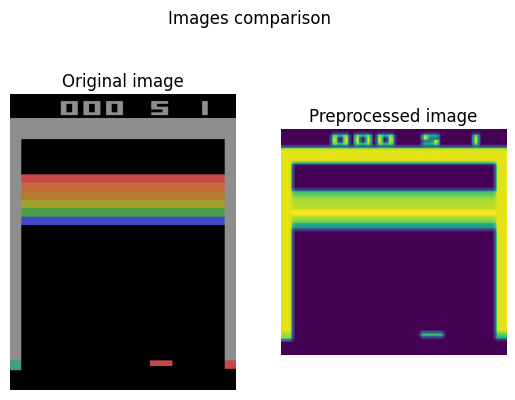

In [12]:
env = gym.make('ALE/Breakout-v5', render_mode="rgb_array")
state_img = env.reset()[0]
print(env.step(1)[1:])
fig,axes = plt.subplots(1,2)
fig.suptitle('Images comparison')
axes[0].set_title('Original image')
axes[0].imshow(state_img)
axes[0].axis('off')
new_img = preprocess_image(state_img)
print(f'{new_img.size() = }')
axes[1].axis('off')
axes[1].set_title('Preprocessed image')
axes[1].imshow(new_img.permute(1,2,0))

In [13]:
Input = namedtuple('input', ('height', 'width', 'n_action'))

def get_input_shapes(env:gym.Env):
  env_tensor = np.zeros(env.observation_space.shape,dtype=np.uint8)
  x = preprocess_image(env_tensor)
  _,height, width = x.shape
  n_action=env.action_space.n
  return Input(height,width,n_action)


Il faut ensuite pouvoir faire en sorte que chaque état corresponde à un séquence d'images réduites du jeu. Nous allons donc créer la classe `StateGenerator`

In [39]:
Action = int
from collections import deque
class StateGenerator():
  def __init__(self,env:gym.Env,seq_len:int, save_frames:bool=True):
    self.env = env
    env_tensor = np.zeros(env.observation_space.shape,dtype=np.uint8)
    x = preprocess_image(env_tensor)
    _,height, width = x.shape
    n_action=env.action_space.n
    self.seq_len = seq_len
    self.stack = torch.zeros(seq_len,height,width)
    self.current_frame = np.ndarray(shape=(height,width,1))
    self.frames_buffer = []
    self.save_frames = save_frames

  def init_env(self):
    self.current_frame  = self.env.reset()[0]
    state = preprocess_image(self.current_frame)
    self.stack[:] =state
    if self.frames_buffer:
      del self.frames_buffer
    if self.save_frames:
      self.frames_buffer = [self.current_frame]
    return self.stack, self.current_frame

  def make_action(self,action:Action):
    next_state,reward,truncated, terminated,info =self.env.step(action)
    self.current_frame = next_state
    next_state = preprocess_image(next_state)
    done = truncated or terminated
    self._update_stack(next_state)
    if self.save_frames:
      self.frames_buffer.append(self.current_frame)
    return self.stack,reward, done, info, self.current_frame

  def _update_stack(self, new_state: torch.Tensor):
        self.stack[:-1] = self.stack[1:].clone()
        self.stack[-1] = new_state
    
  def generat_gif(self,output_file:str):
    if not self.save_frames:
      raise Exception('You must set save_frames to True to generate a gif')
    frames = [Image.fromarray(f, mode='RGB') for f in self.frames_buffer]
    frames[0].save(output_file, format='GIF', append_images=frames[1:], save_all=True, duration=10, loop=0)
    print(f'Saving {output_file}')
    

  def reset_stack(self):
    self.stack = torch.zeros(self.seq_len, 1, *self.stack.shape[2:])
  
  def reset_frames_buffer(self):
    del self.frames_buffer
    self.frames_buffer = []


In [40]:
env = gym.make('ALE/Breakout-v5', render_mode="rgb_array")
sg = StateGenerator(env,5)
sg.init_env()
for i in range(500):
    action = env.action_space.sample()
    sg.make_action(action)

sg.generat_gif(os.path.join(IMG_DIR,'test.gif'))
sg.reset_stack()
sg.reset_frames_buffer()

Saving test.gif


![gif](./test.gif)

### Elaboration de modèles de de DQN

Ici deux modèles vont être implémentés pour étudier quelle est la stratégie la plus adaptée.

#### DQN simple

Le premier dispose de 3 couches de convolutions et d'une couche linaire. Le tenseur de sorti correspond aux Q values de chaque action.

In [26]:
class DQN(nn.Module):
    def __init__(self, n_action, height, width,seq_len=1 ,linear_size=1024, model_name=None,):
        super(DQN, self).__init__()
        self.input_dimension = seq_len, height, width
        self.conv1 = nn.Conv2d(in_channels=seq_len, out_channels=32, kernel_size=8, stride=4)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        x0 = torch.zeros(1, seq_len, height, width)
        x0 = self.convolute(x0)
        x0 = self.flatten(x0)
        flatten_dim = x0.shape[1]

        self.linear1 = nn.Linear(flatten_dim, linear_size)
        self.relu4 = nn.ReLU()
        self.linear2 = nn.Linear(linear_size, n_action)

    def flatten(self, x):
        return x.view(x.shape[0], -1)

    def convolute(self,x):
      x = self.conv1(x)
      x = self.relu1(x)
      x = self.conv2(x)
      x = self.relu2(x)
      x = self.conv3(x)
      x = self.relu3(x)
      return x

    def forward(self, x):
      x = self.convolute(x)

      x = self.flatten(x)

      x = self.linear1(x)
      x = self.relu4(x)
      return self.linear2(x)

Le second est un  dueling network, il décompose la valeur d'action en deux parties: la valeur de l'état (à quel point l'état actuel est cool) et l'avantage de l'action (à quel point choisir cette action par rapport aux autres est cool). Cela permet au réseau de mieux comprendre ce qui se passe dans le jeu et d'apprendre de manière plus efficace.

In [27]:


class DuellingDQN(nn.Module):
    def __init__(self, n_action, height, width, seq_len =1,linear_size=1024, model_name=None):
        super(DuellingDQN, self).__init__()
        self.input_dimension = seq_len, height, width
        self.model_name = model_name
        self.conv1 = nn.Conv2d(in_channels=self.input_dimension[0], out_channels=64, kernel_size=8, stride=4)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        x0 = torch.zeros(1, seq_len, height, width)
        x0 = self.convolute(x0)
        x0 = self.flatten(x0)
        flatten_dim = x0.shape[1]
        self.value = nn.Linear(flatten_dim,1)
        self.advantage = nn.Linear(flatten_dim,n_action)



    def flatten(self, x):
        return x.view(x.shape[0], -1)

    def convolute(self,x):
      x = self.conv1(x)
      x = self.relu1(x)
      x = self.conv2(x)
      x = self.relu2(x)
      x = self.conv3(x)
      x = self.relu3(x)
      return x

    def forward(self, x):
      x = self.convolute(x)
      x = self.flatten(x)
      value = self.value(x)
      advantage = self.advantage(x)
      q_value = value + (advantage - advantage.mean(dim=1,keepdim=True))
      return q_value

Vérifions l'homogénéité des shapes d'entrée et de sortie

In [28]:
env = gym.make('ALE/Breakout-v5', render_mode="rgb_array")
input_data = get_input_shapes(env)

dqn = DQN(input_data.n_action,input_data.height,input_data.width)
duelling_dqn = DuellingDQN(input_data.n_action,input_data.height,input_data.width)

x = preprocess_image(env.reset()[0])
x = x.unsqueeze(0)

for model in [dqn, duelling_dqn]:
  output = model(x)
  assert output.size(1) == env.action_space.n, print(f'{output.size(1)} != {env.action_space.n}')
  print("Les shapes de sortie du modèle sont cohérentes.")
  print(f'{output.size()}')

Les shapes de sortie du modèle sont cohérentes.
torch.Size([1, 4])
Les shapes de sortie du modèle sont cohérentes.
torch.Size([1, 4])


#### Gestion de la mémoire des expériences

Le but est de stocker les états précédents afin de permettre un meilleur apprentissage des Q values. Nous allons donc créer la classe `ExpStack`, qui génèrera des batchs aléatoires. La taille d'une telle structure est plafonnée afin d'éviter que la mémoire ne sature.

In [29]:
GameTransition = namedtuple('game_transition', ('initial_state', 'action', 'reward','next_state', 'done'))

In [30]:
class ExpStack(): # D
  def __init__(self, max_size:int, seq_len:int = 4):
    self.transitions = []
    self.max_size = max_size # N
    self.index = 0
    self.seq_len = seq_len

  def enqueue(self,transition:GameTransition):
    if (len(self.transitions) < self.max_size):
      self.transitions.append(transition)
    else:
      self.transitions[self.index] = transition
    self.index +=1
    self.index = self.index % self.max_size

  def get_experiences(self,nb_exp=1):
    return random.sample(self.transitions, nb_exp)

  def __len__(self):
    return len(self.transitions)

  def __getitem__(self,index):
    return self.transitions[index]

  def sample_minibatch(self,batch_size:int=32):
    if (batch_size>len(self)):
      return self.transitions

    return random.sample(self.transitions, batch_size)

  def tensor_batch(self,batch_size):
    batch = random.sample(self.transitions, batch_size)
    batch = GameTransition(*(zip(*batch)))
    initial_state = torch.stack(batch.initial_state)

    next_state = torch.stack(batch.next_state)

    reward = torch.tensor(batch.reward)
    reward = reward.unsqueeze(1)

    done = torch.tensor(batch.done).float()
    done = done.unsqueeze(1)

    action = torch.tensor(batch.action)
    action = action.unsqueeze(1)

    return GameTransition(initial_state,action,reward,next_state,done)


### Lancement du modèle sur l'algorithme **"deep Q-learning with experience replay."** issu de l'article

#### Implémentation de l'Agent

Nous allons créer la classe `DQNAgent` qui va pouvoir entraîner un modèle et mettre à jour $\hat{Q}$.

In [31]:
State = torch.Tensor

In [42]:
class DQNAgent():
  epsilon = 0.05
  batch_size = 32
  gamma = 0.9
  max_experiences:int = 2500
  def __init__(self, env: gym.Env,

               seq_len:int=5,
               verbose:bool=True,
               model_file:str=None,
               model:nn.Module=None):
    self.state_gen = StateGenerator(env,seq_len=seq_len)
    self.seq_len = seq_len
    self.model = model
    self.target_model = copy.deepcopy(self.model)
    self.target_model.eval()

    self.experiences = ExpStack(max_size=self.max_experiences,seq_len=1)
    self.legal_actions = list(range(env.action_space.n))

    self.loss_evolution = []
    self.optimizer = torch.optim.Adam(self.model.parameters())
    self.loss_func = nn.MSELoss()

    self.epoch_count = 0
    
    if (model_file is None):
      self.model_file = 'model.pt'
    else:
      self.model_file = model_file
  
  def clear_experiences(self):
    del self.experiences
    self.experiences = ExpStack(self.max_experiences)

  def train_model(self) -> None:
    self.model.train()
    self.epoch_count +=1
    if (len(self.experiences) >= self.batch_size):
      batch = self.experiences.tensor_batch(self.batch_size)
      y_target = (1 - batch.done ) * self.target_model(batch.next_state) * self.gamma + batch.reward
      y_target = y_target.max(1)[0].unsqueeze(1)
      y_pred = self.model(batch.initial_state).gather(1,batch.action)
      loss = self.loss_func(y_target,y_pred)
      del y_target, y_pred, batch
      self.optimizer.zero_grad()
      loss.backward()
      self.loss_evolution.append(loss.item())
      self.optimizer.step()

      return loss.item()

  def make_action(self, action: Action) -> tuple[State,float, bool,dict,np.array]:
    res = self.state_gen.make_action(action)
    assert res[0].shape[0] == self.seq_len, f'{res[0].shape} is wrong'
    return res


  def get_action(self,current_state: State) -> Action:
    if(random.random() < self.epsilon):
      return random.choice(self.legal_actions)

    current_state = current_state.unsqueeze(0)
    model_output = self.model(current_state)
    action = model_output.argmax().item()
    return action

  def update_parameters(self) -> None:
    self.target_model.load_state_dict(self.model.state_dict())
    self.target_model.eval()

  def save_model(self,file_name:str=None) -> None:
    if (file_name is None):
      torch.save(self.model,self.model_file+'.pt')
    else:
      torch.save(self.model,file_name)
    


  def generate_gif(self, output_file:str) -> None:

    self.state_gen.generat_gif(output_file)

La classe `Trainer` est ensuite définie dans le but de pouvoir entraîner un `DQNAgent`.

In [53]:
class Trainer:
  max_step = int(1e5)
  epsilon = 0.05
  batch_size = 32
  gamma = 0.9
  update_frequency = 5
  def __init__(self, agent: DQNAgent, verbose:bool=True,time_limit=3600,nb_episodes:int=25000,name:str=None):
      self.agent = agent
      self.verbose = verbose
      self.epochs_count = 0
      self.stop = False
      self.time_limit = time_limit
      self.nb_episodes = nb_episodes
      self.rewards = []

  def train_agent(self,save_model :bool =True, gif_file:str=None):
      episode_index = 0
      total_reward = 0
      self.reboot_timer()
      self.rewards = []
      max_reward = 0
      while episode_index < self.nb_episodes and not self.stop:
          reward = self.play()
          self.rewards.append(reward)
          episode_index += 1
          total_reward+=reward
          if(reward > max_reward):
            max_reward = reward
            model_file_path = os.path.join(MODEL_DIR,self.agent.model_file+'.pt')
            self.agent.save_model(model_file_path)
            self.log(f'Saving model to {model_file_path}')
            gif_file_path = os.path.join(IMG_DIR,self.agent.model_file+'.gif')
            self.agent.generate_gif(gif_file_path)
            
          self.rewards.append(reward)
          self.log(f'Episode {episode_index} is done')
          self.log(f'Total reward {reward}')
      if(save_model):
        self.agent.save_model(os.path.join(MODEL_DIR,self.agent.model_file+'.pt'))
      if(gif_file is not None):
        self.agent.generate_gif(gif_file)
      return total_reward/episode_index



  def log(self, *args,**kwargs):
    if(self.verbose):
      print(*args,**kwargs)

  def reboot_timer(self):
    self.begin_time = time()
    self.stop = False

  def update_time(self):
    current_time = int(time())
    delta = current_time - self.begin_time
    self.stop = delta > self.time_limit
    if(self.stop):
      self.log(f'TIME OUT: Model stops training after {delta:.2f} seconds, Save model to {self.agent.model_file}.pt')


  def play(self, train:bool=True,keep_frame:bool=False):
      done = False
      step_index = 0
      agent = self.agent
      current_state,frame = agent.state_gen.init_env()
      

      total_reward = 0

      while step_index < self.max_step and not done and not self.stop:
          self.update_time()
          a_t = agent.get_action(current_state=current_state)
          next_state, reward, done, info, next_state_frame = agent.make_action(a_t)
          assert next_state.shape[0] == (agent.seq_len), "Bad Shapes"
          assert current_state.shape[0] == (agent.seq_len), "Bad Shapes"
          
          total_reward += reward
          if train:
              transition = GameTransition(current_state, a_t, reward, next_state, done)
              agent.experiences.enqueue(transition)
              loss = agent.train_model()
              if step_index % self.update_frequency == 0:
                  agent.update_parameters()
              
          if done:
              self.log(f'Game over after {step_index} steps')
          current_state = next_state
          step_index += 1

      return total_reward

Nous allons donc entraîner les deux agents avec les réseaux `DQN` et `DuellingDQN`

TIME OUT: Model stops training after 0.57 seconds, Save model to simple_dqn.pt
Episode 1 is done
Total reward 0.0
Game over after 196 steps
Saving img/simple_dqn_final.gif
TIME OUT: Model stops training after 0.42 seconds, Save model to duelling_dqn.pt
Episode 1 is done
Total reward 0.0
Game over after 121 steps
Saving img/duelling_dqn_final.gif


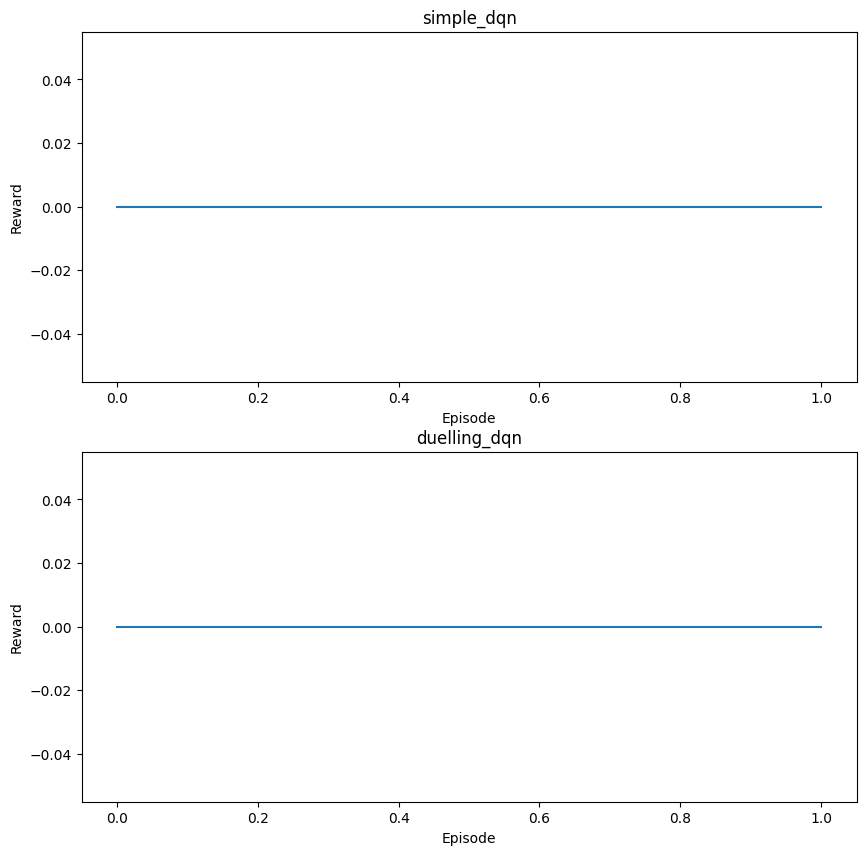

In [54]:
seq_len = 5
TIME_LIMIT = 2*3600
env_name = 'ALE/Breakout-v5'
env = gym.make(env_name, render_mode="rgb_array")

model_types = ['simple_dqn', 'duelling_dqn']
simple_dqn = DQN(input_data.n_action, input_data.height, input_data.width,seq_len=seq_len)
duelling_dqn = DuellingDQN(input_data.n_action, input_data.height, input_data.width,seq_len=seq_len)
models = [simple_dqn,duelling_dqn]
agents = []
fig = plt.figure(figsize=(10,10))
for model,model_type in zip(models,model_types):
  agent = DQNAgent(env,model_file=model_type,model=model)
  trainer = Trainer(agent,time_limit=TIME_LIMIT,name=model_type)
  mean_reward = trainer.train_agent()
  agent.clear_experiences()
  agents.append(agent)
  trainer.reboot_timer()
  trainer.play(train=False,keep_frame=True)
  ax = fig.add_subplot(2,1,models.index(model)+1)
  ax.plot(trainer.rewards,label='rewards')
  ax.set_title(model_type)
  ax.set_xlabel('Episode')
  ax.set_ylabel('Reward')

  agent.generate_gif(os.path.join(IMG_DIR,f'{model_type}_final.gif'))
fig.savefig(os.path.join(IMG_DIR,'rewards.png'))

[](./simple_dqn.gif)